In [168]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Dense, Input, ReLU, Embedding, Reshape, LeakyReLU, Flatten, Dropout
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, BatchNormalization, Conv2D, MaxPool2D
from keras.models import Model

from tensorflow.keras.datasets import mnist

# Data preparation

In [170]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

In [171]:
x_train.shape

(60000, 28, 28)

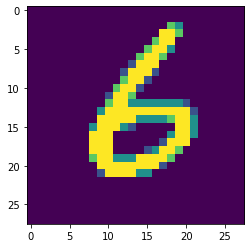

In [255]:
plt.imshow(x_train[66]);

# Generator

In [175]:
input_noise = Input(shape=(10,), name='Input_noise')
noise = Dense(7*7*128, activation='ReLU')(input_noise)
noise = ReLU()(noise)
noise = Reshape((7, 7, 128), name='Reshape_noise')(noise)

label_input = Input(shape=(1,))
label = Embedding(10, 50)(label_input)
label = Dense(7 * 7, activation='ReLU')(label)
label = Reshape((7, 7, 1))(label)

image = Concatenate()([label, noise])

image = Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(image)
image = ReLU()(image)
image = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(image)
image = ReLU()(image)
image = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(image)

generator = Model([input_noise, label_input], image, name='Generator')


# Discriminator 

In [177]:
input_label = Input(shape=(1,))
label = Embedding(10, 50)(input_label)
label = Dense(28 * 28, activation='ReLU')(label)
label = Reshape((28, 28, 1))(label)

input_image = Input(shape=(28, 28, 1))

concat = Concatenate()([input_image, label])

h = Conv2D(64, kernel_size=(3, 3), padding='same')(concat)
h = LeakyReLU(alpha=0.2)(h)
h = Conv2D(128, kernel_size=(3, 3), padding='same')(h)
h = LeakyReLU(alpha=0.2)(h)
h = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(h)
h = Flatten()(h)
h = Dropout(0.2)(h)
h = Dense(1, activation="sigmoid")(h)

discriminator = Model([input_image, input_label], h, name='Discriminator')

# Conditional GAN

In [179]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [192]:
def generator_loss(fake):
    loss = cross_entropy(tf.ones_like(fake), fake)
    return loss

In [193]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(0.001)
disc_optimizer = tf.keras.optimizers.Adam(0.001)

In [205]:
def train_step(real_images, labels):
    noise = tf.random.normal([BATCH_SIZE, 10])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        
        real_out = discriminator([real_images, labels], training=True)
        fake_out = discriminator([generated_images, labels], training=True)
        
        gen_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))
    
    return gen_loss, disc_loss
        

In [206]:
def train(EPOCHS=20, BATCH_SIZE):
    for ep in range(EPOCHS):
        for batch in range(len(x_train)//BATCH_SIZE):
            start = batch*BATCH_SIZE
            end = (batch+1)*BATCH_SIZE
            images, labels = x_train[start:end], y_train[start:end]
            gen_loss, disc_loss = train_step(images, labels)
        print(f"Завершена Эпоха: {ep}, gen_loss: {gen_loss}, disc_loss: {disc_loss}")

# Model Training

In [ ]:
BATCH_SIZE=30
train(20, BATCH_SIZE)

# Test the model

In [ ]:
def print_img(pred):
    fig = plt.figure(figsize=(20, 20))
    columns = 10
    rows = 1
    for i in range(1, columns*rows +1):
        img = pred[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

In [252]:
new_gen = tf.keras.models.load_model('digits_generator')

In [253]:
x = np.random.rand(10, 10)
y = np.asarray([i for i in range(10)])
pred = new_gen.predict([x, y])

1/1 [==============================] - 0s 203ms/step


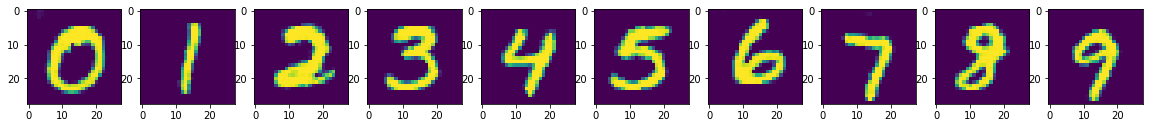

In [254]:
print_img(pred)